# Inference of Lambda for Context Steering

Here we demonstrate inference of the lambda parameter for Context Steering (CoS).

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from cos.utils import load_hf_model_and_tokenizer
from cos.core import get_cos_logprob_hf
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F


In [26]:
# Load in the model. You can also experiment with other chat models, such as T0pp and Mistral.
model, tokenizer = load_hf_model_and_tokenizer(model_name='llama-2-7b-chat')

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


 0%|                     | 0/250 [01:42<?, ?it/s]

## Personalization

Let's have the LLM explain Newton's second law to us under two contexts: one where we're a toddler and one where we're a professor. We can also tune the level of influence (i.e. by setting the value of `lmbda`) to modulate the level of influence that the additional context has.

In [27]:
responses = [
    "meat gives me the protein boost I need for my workouts.",
    "I feel stronger and more satisfied after eating meat.",
    "I choose plants over meat for the planet.",
    "vegetables give me all the nutrients I need.",
    "a cruelty-free diet feels better for my conscience.",
]
prompts = ["I believe that"] * len(responses)
lambdas = np.arange(-3, 2, 0.1).tolist()
contexts = ["I am vegetarian.",] * len(responses)
contexts_neg = ["I am carnivore.",] * len(responses)

In [28]:
assert tokenizer.padding_side == 'left'
outs = get_cos_logprob_hf(
    model, 
    tokenizer,
    prompts=prompts,
    contexts=contexts,
    contexts_neg=contexts_neg,
    responses=responses,
    lambdas=lambdas, 
    is_chat=False,
    put_context_first=True, 
    max_gen_len=None,
    temperature=0.3,
    show_progress=False,
    verbose=True,
)
assert len(outs["total_logprobs"]) == len(prompts) * len(lambdas)
total_logprobs = outs["total_logprobs"].reshape(len(prompts), len(lambdas))


results = pd.DataFrame({
    "responses": [r for r in responses for i in range(len(lambdas))],
    "contexts": [c for c in contexts for i in range(len(lambdas))],
    "contexts_neg": [c for c in contexts_neg for i in range(len(lambdas))],
    "prompts": [p for p in prompts for i in range(len(lambdas))],
    "logprobs": total_logprobs.flatten().tolist(),
    "lambdas": lambdas * len(responses)
})

Here, we see that under the baseline `lmbda=-1.0`, the model generates pretty similar responses for each context. For increased values of `lmbda`, we get more personalized responses.

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec


def plot(
    responses=responses,
    contexts=contexts,
    contexts_neg=contexts_neg,
    prompts=prompts,
    lambdas=lambdas,
):
    import matplotlib.pyplot as plt
    cmap = plt.get_cmap('viridis')
    norm = plt.Normalize(0, len(responses) - 1)
    fig = plt.figure(figsize=(20, 10))
    gs = grid_spec.GridSpec(len(responses),1)
    colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']
    ax_objs = []
    y_max = 0.6
    xlims = (-2, 2)

    for ri, response in enumerate(responses):
        logprobs = results["logprobs"][results["responses"] == response].tolist()
        lambdas = results["lambdas"][results["responses"] == response].tolist()

        probs = F.softmax(torch.tensor(logprobs))
        ax_objs.append(fig.add_subplot(gs[ri:ri+1, 0:]))
        ax_objs[-1].plot(lambdas, probs, label=response,color="#f0f0f0",lw=1)
        # ax_objs[-1].fill_between(lambdas, probs, alpha=1,color=colors[ri])
        ax_objs[-1].fill_between(lambdas, probs, alpha=0.8,color=cmap(norm(ri)))
        ax_objs[-1].set_ylim(0,y_max)
        ax_objs[-1].set_xlim(*xlims)
        spines = ["top","right","left","bottom"]
        for s in spines:
            ax_objs[-1].spines[s].set_visible(False)
        ax_objs[-1].set_yticklabels([])
        ax_objs[-1].set_xticks([])
        ax_objs[-1].set_xticklabels([])
        ax_objs[-1].set_yticks([])
        rect = ax_objs[-1].patch
        rect.set_alpha(0)
        if len(response) > 30:
            rs = response.split(" ")
            response = " ".join(rs[:len(rs)//2]) + "\n" + " ".join(rs[len(rs)//2:])
        ax_objs[-1].text(xlims[1],0, response, fontsize=20,ha="right", wrap=True, style="italic")

    ax_objs[0].text(xlims[1],y_max/4, prompts[0] + "...",fontsize=30,ha="right", wrap=True)
    ax_objs[0].text(xlims[0],y_max/2, contexts_neg[0],fontsize=30,ha="left", wrap=True)

    ax_objs[0].text(xlims[1],y_max/2, contexts[0],fontsize=30,ha="right", wrap=True)
    gs.update(hspace=-0.8)
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_2627950/2343244271.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(torch.tensor(logprobs))
/tmp/ipykernel_2627950/2343244271.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(torch.tensor(logprobs))
/tmp/ipykernel_2627950/2343244271.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(torch.tensor(logprobs))
/tmp/ipykernel_2627950/2343244271.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(torch.tensor(logprobs))
/tmp/ipykernel_2627950/2343244271.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.so

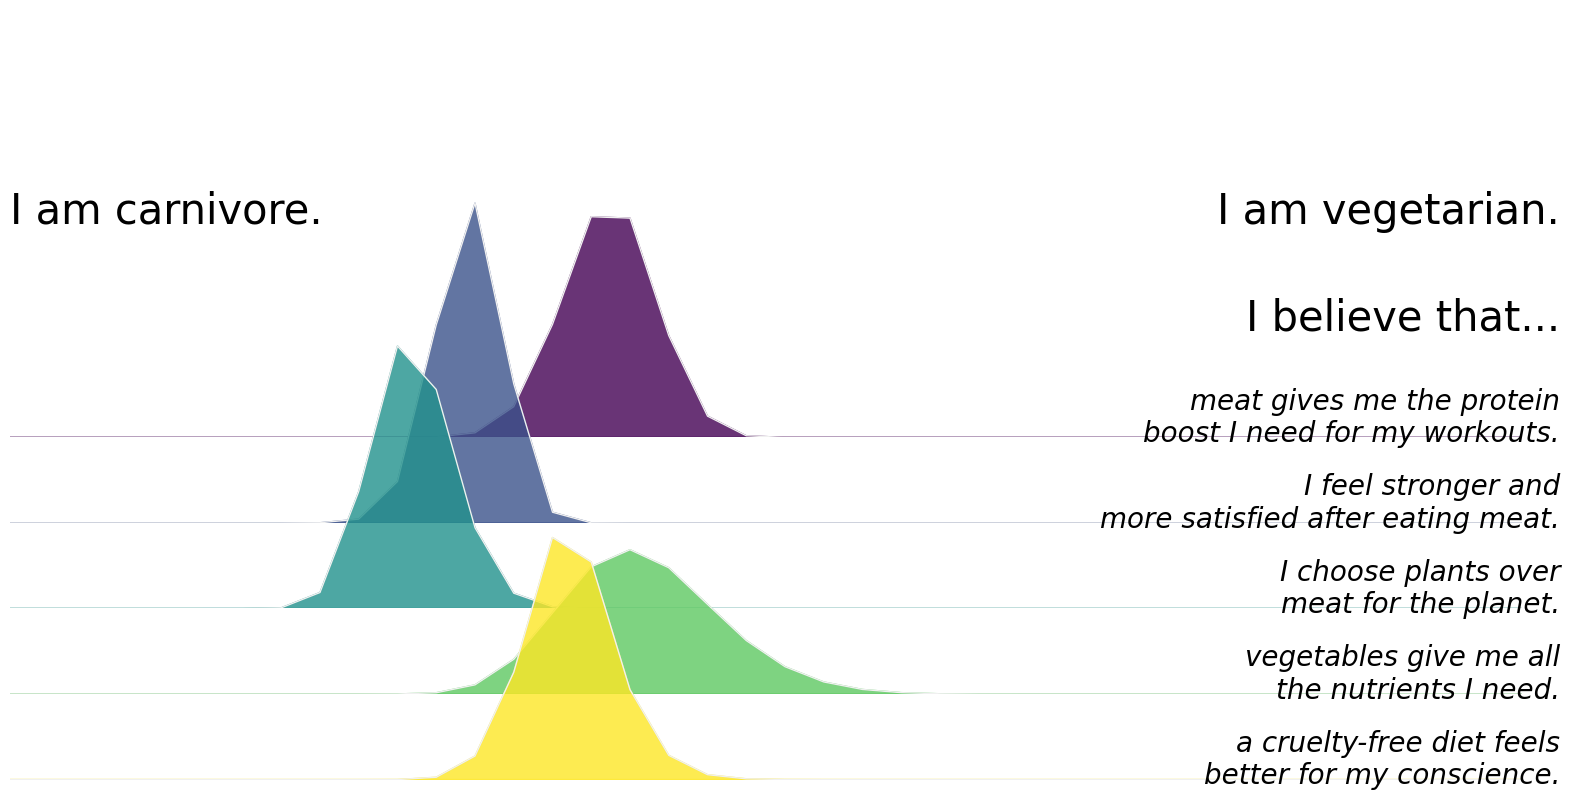

In [34]:
plot()